In [1]:
%matplotlib notebook
import tifffile
import matplotlib.pyplot as plt
from scipy.signal import medfilt
import mahotas as mh
from colicoords import iter_subplots
import numpy as np
from symfit import Parameter, Variable, Fit, Model, exp
import os

In [2]:
def generate_background(image, median_kernel=11, gaussian_kernel=11, dtype=int):
    assert median_kernel % 2 == 1
    assert image.ndim == 2
    sp_m = medfilt(image, kernel_size=median_kernel)

    #fill corners
    cz = int((median_kernel - 1) / 2)
    sp_m[:cz, :cz] = sp_m[cz, cz]
    sp_m[:cz, -cz:] = sp_m[cz, -cz]
    sp_m[-cz:, -cz:] = sp_m[-cz, -cz]
    sp_m[-cz:, :cz] = sp_m[-cz, cz]

    gf = mh.gaussian_filter(sp_m, gaussian_kernel)

    return gf.astype(dtype)

In [3]:
import symfit
symfit.__version__

'0.5.1'

In [4]:
import colicoords
colicoords.__version__

'0.0.0'

In [6]:
data_dir = r'F:\data\t3ss\20191001_deltaescv_c41_eyfp-escv_repeat_02' 
output_dir = r'F:\_processed_big\t3ss\20191001_deltaescv_c41_eyfp-escv_repeat_02'

In [7]:
df = tifffile.imread(os.path.join(data_dir, 'Image', 'dark.tif'))
df.shape

(512, 512)

In [8]:
c41_bf = tifffile.imread(os.path.join(data_dir, 'c41', '_BF_140_.tif'))
epec_bf = tifffile.imread(os.path.join(data_dir, 'epec', '_BF_140_.tif'))

In [9]:
c41_bf.shape, epec_bf.shape

((2200, 512, 512), (1200, 512, 512))

<IPython.core.display.Javascript object>


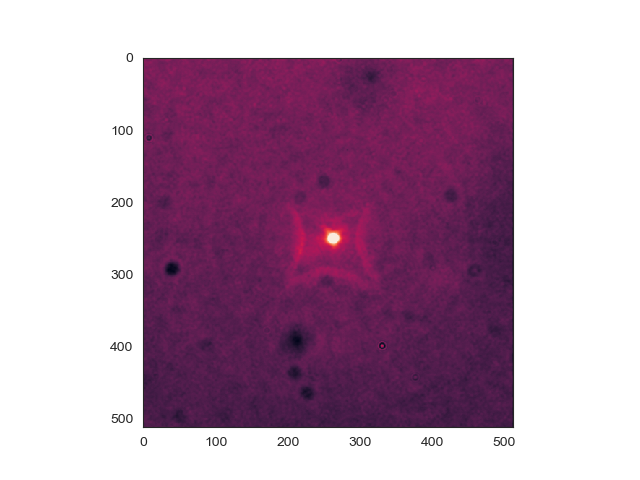

In [10]:
c41_median = np.median(c41_bf, axis=0)
c41_median.shape

plt.figure()
plt.imshow(c41_median)

In [11]:
bf_flat_c41 = (c41_bf - df) / (c41_median - df)

<IPython.core.display.Javascript object>


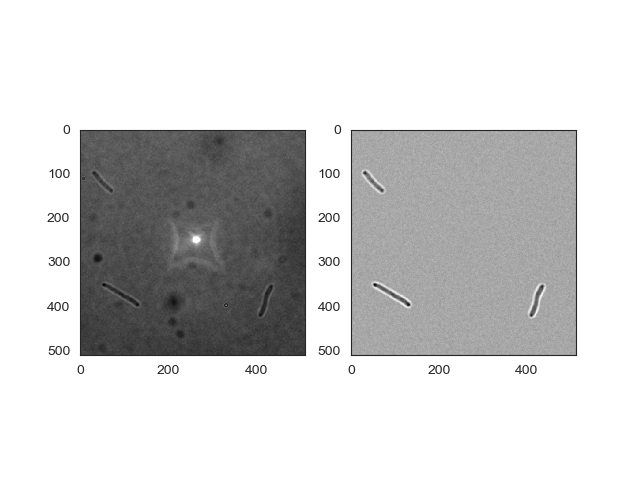

In [12]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(c41_bf, cmap='gray')
ax2.iter_imshow(bf_flat_c41, cmap='gray')
fig.display()

In [13]:
np.save(os.path.join(output_dir, 'BF_C41_flat.npy'), bf_flat_c41)

In [14]:
bf_flat_c41.shape

(2200, 512, 512)

<IPython.core.display.Javascript object>


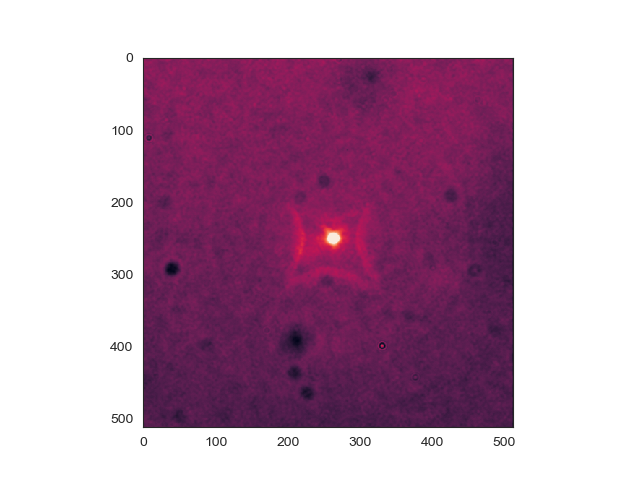

In [15]:
epec_median = np.median(epec_bf, axis=0)
epec_median.shape

plt.figure()
plt.imshow(epec_median)

In [16]:
bf_flat_epec = (epec_bf - df) / (epec_median - df)

<IPython.core.display.Javascript object>


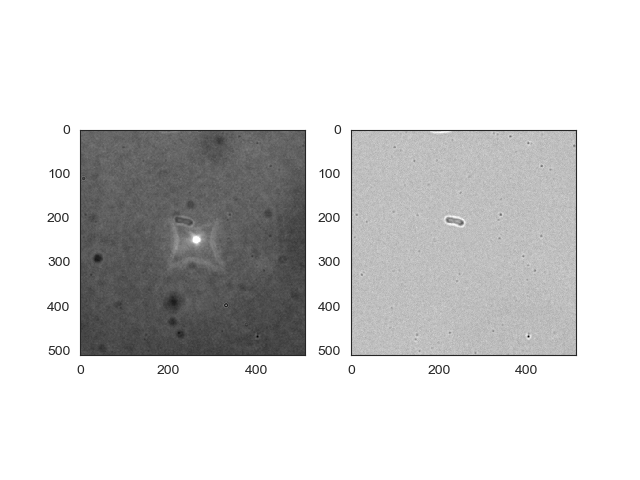

In [17]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(epec_bf, cmap='gray')
ax2.iter_imshow(bf_flat_epec, cmap='gray')
fig.display()

In [18]:
np.save(os.path.join(output_dir, 'BF_EPEC_flat.npy'), bf_flat_epec)

## Beamprofile

In [19]:
images = ['Image_004.tif', 'Image_005.tif', 'Image_006.tif', 'Image_007.tif']
bps = [tifffile.imread(os.path.join(data_dir, 'Image', f)) for f in images]

In [24]:
bp = np.stack(bps)
bp.shape

(4, 512, 512)

In [8]:
bp.shape

(12, 512, 512)

<IPython.core.display.Javascript object>


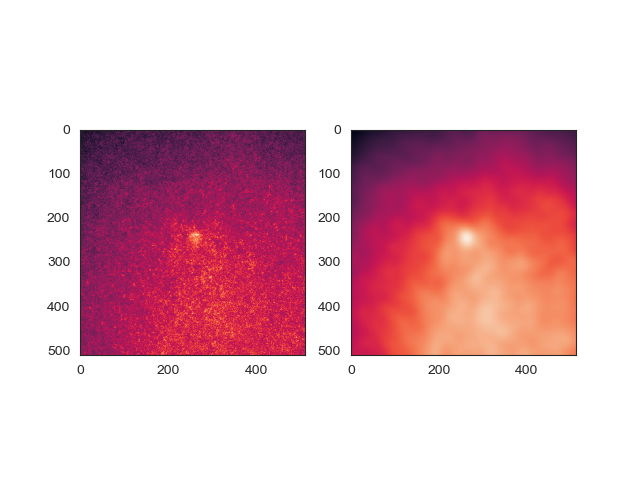

In [25]:
smoothed = generate_background(np.mean(bp, axis=0))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.mean(bp, axis=0))
ax2.imshow(smoothed)

In [26]:
def model_gauss2d(a_val, x_mu_val, y_mu_val, sig_x_val, sig_y_val, base, has_base=True):
    a = Parameter(name='a', value=a_val)
    sig_x = Parameter(name='sig_x', value=sig_x_val)
    sig_y = Parameter(name='sig_y', value=sig_y_val)
    x_mu = Parameter(name='x_mu', value=x_mu_val)
    y_mu = Parameter(name='y_mu', value=y_mu_val)
    if has_base:
        b = Parameter(name='b', value=base)
    else:
        b = base
    x_var = Variable(name='x_var')
    y_var = Variable(name='y_var')
    z_var = Variable(name='z_var')

    model = {z_var: a*exp(-( ((x_var-x_mu)**2/(2*sig_x**2)) + ((y_var-y_mu)**2 / (2*sig_y**2)) )) + b}
    return model

def fit_gauss2d(arr):
    Y, X = np.indices(arr.shape)

    total = arr.sum()
    x = (X*arr).sum()/total
    y = (Y*arr).sum()/total
    col = arr[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-y)**2*col).sum()/col.sum())
    row = arr[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-x)**2*row).sum()/row.sum())
    base = 1800
    
    
    idx = np.argmax(arr)
    y_mu, x_mu = np.unravel_index(idx, arr.shape)

    print(arr.max(), x_mu, y_mu, width_x, width_y, base)
    model = model_gauss2d(arr.max(), x_mu, y_mu, width_x, width_y, base, has_base=True)

    fit = Fit(model, z_var=arr, x_var=X, y_var=Y)
    return fit.execute(), fit.model

In [27]:
res, model = fit_gauss2d(smoothed)

21125 262 247 308.4411046890725 299.61783098028656 1800


In [28]:
X, Y = np.indices(smoothed.shape)

In [29]:
z = model(x_var=X, y_var=Y, **res.params)[0]

<IPython.core.display.Javascript object>


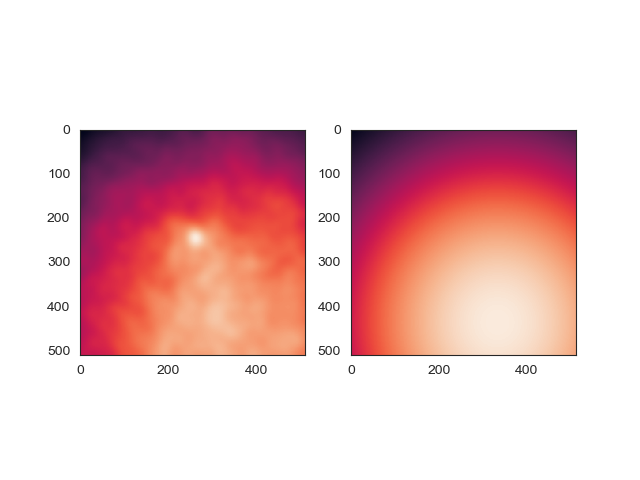

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(smoothed)
ax2.imshow(z.T)

<IPython.core.display.Javascript object>


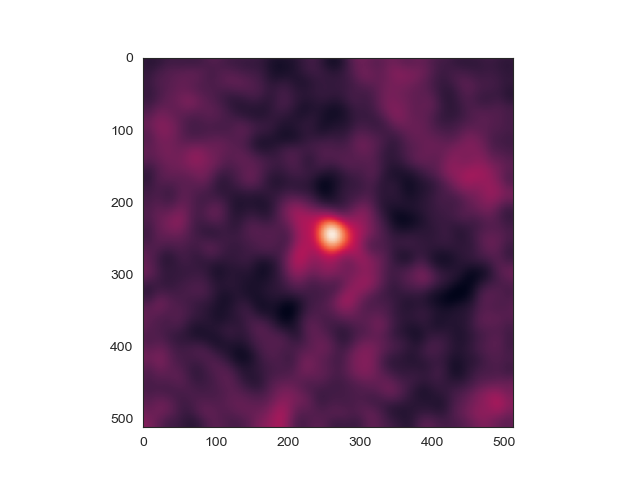

In [31]:
plt.figure()
plt.imshow(smoothed - z.T)

In [32]:
bp_final = z.T - df
bp_final /= bp_final.max()
bp_final.max()

1.0

<IPython.core.display.Javascript object>


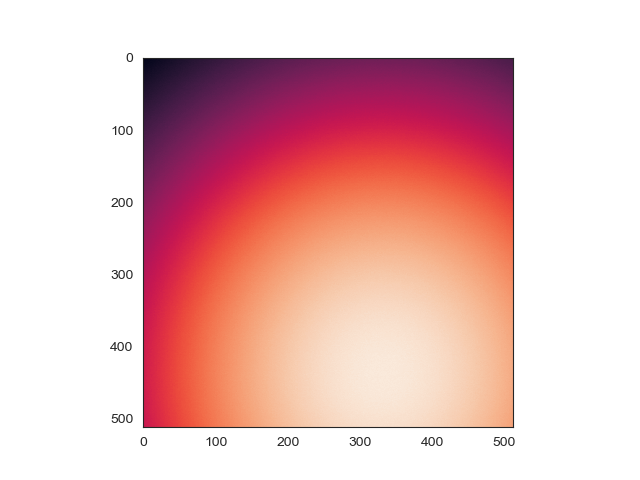

In [33]:
plt.figure()
plt.imshow(bp_final)

In [34]:
tifffile.imsave(os.path.join(output_dir, 'beamprofile.tif'), bp_final)

In [35]:
np.save(os.path.join(output_dir, 'beamprofile.npy'), bp_final)

In [36]:
c = 'c41'
arr = tifffile.imread(os.path.join(data_dir, c, '_514_.tif')).astype(float)
arr.shape

(4400, 512, 512)

In [39]:
reshaped.shape

(100, 44, 512, 512)

In [53]:
reshaped = arr.reshape(-1, 100, 512, 512)
g100 = reshaped[0::2, :, :, :].reshape(-1, 512, 512)
g500 = reshaped[1::2, :, :, :].reshape(-1, 512, 512)
g100.shape, g500.shape

((2200, 512, 512), (2200, 512, 512))

<IPython.core.display.Javascript object>


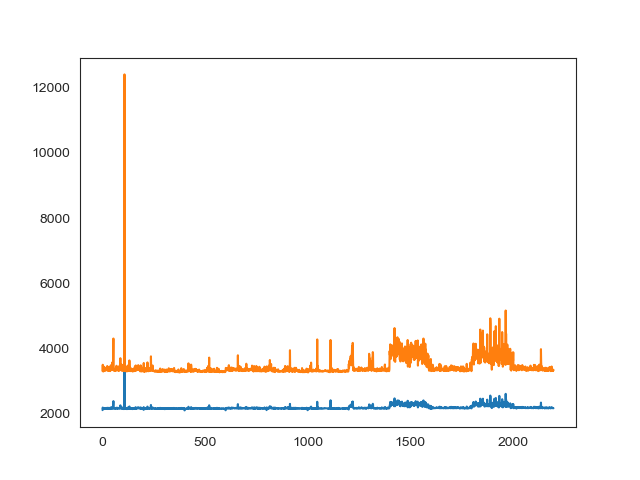

In [54]:
plt.figure()
plt.plot(g100.mean(axis=(1,2)))
plt.plot(g500.mean(axis=(1,2)))

In [59]:
df.mean()

1991.5889167785645

In [71]:
cells = ['c41', 'epec']

for c in cells:

    arr = tifffile.imread(os.path.join(data_dir, c, '_514_.tif')).astype(float)
    reshaped = arr.reshape(-1, 100, 512, 512)
    g100 = reshaped[0::2, :, :, :].reshape(-1, 512, 512)
    g500 = reshaped[1::2, :, :, :].reshape(-1, 512, 512)
    g100 -= df
    g500 -= df
    g100 /= bp_final   
    g500 /= bp_final
    
    np.save(os.path.join(output_dir, '{}_G100.npy'.format(c)), g100)
    np.save(os.path.join(output_dir, '{}_G500.npy'.format(c)), g500)

In [42]:
plt.figure()
plt.plot(g100.mean(axis=(1,2)))
plt.plot(g500.mean(axis=(1,2)))

(512, 512)

<IPython.core.display.Javascript object>


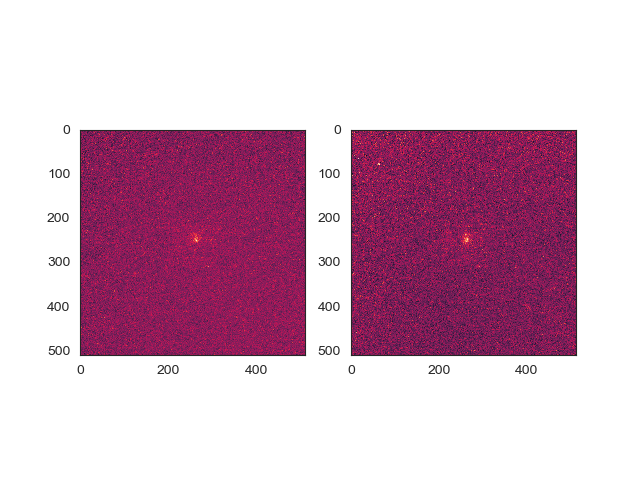

In [73]:
fig, (ax1, ax2) = iter_subplots(1, 2)
ax1.iter_imshow(g100)
ax2.iter_imshow(g500)
fig.display()

<IPython.core.display.Javascript object>


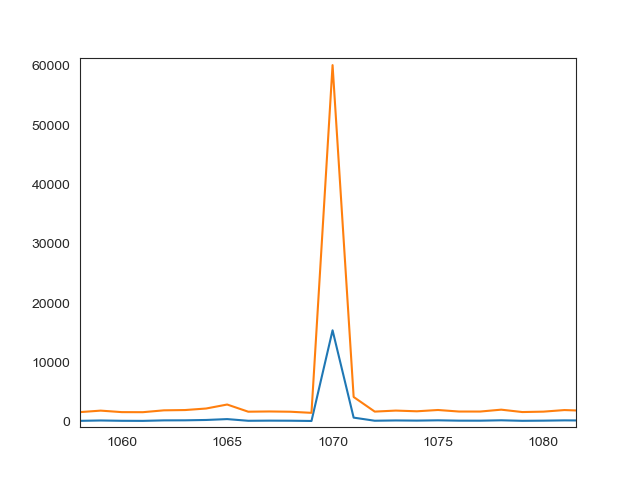

In [74]:
plt.figure()
plt.plot(g100.mean(axis=(1,2)))
plt.plot(g500.mean(axis=(1,2)))